In [2]:
from scipy.signal import savgol_filter

def noise_filter(dataframe):
    for column in dataframe.columns:
        dataframe[column] = savgol_filter(dataframe[column], 10, 2, axis=0)
    return dataframe



In [167]:
def find_time_features(data, name):
    columns = [name + "_mean", name + "_std", name + "_range", name + "_IRQ"]
    properties = [np.mean(data), np.std(data), np.max(data) - np.min(data),
                  np.quantile(data, 0.75) - np.quantile(data, 0.25)]
    d = pd.DataFrame(data=properties).T
    d.columns = columns
    return d

In [161]:
def compute_time_features(df):
    data_total = pd.DataFrame()
    for column in df.columns:
        temp = find_time_features(df[column], column)
        data_total = pd.concat([data_total, temp], axis=1)
    return data_total

In [162]:
def find_fft_points(data, name):
    (indices_peaks, peaks) = compute_peaks(data)
    columns_x=[name + "X#1", name + "X#2", name + "X#3", name + "X#4", name + "X#5"]
    columns_y=[name + "P#1", name + "P#2", name + "P#3", name + "P#4", name + "P#5"]
    x_p = pd.DataFrame(data=indices_peaks).T
    x_p.columns = columns_x
    y_p = pd.DataFrame(data=peaks).T
    y_p.columns = columns_y
    tot_p = pd.concat([x_p, y_p], axis=1)
    return tot_p

In [70]:
def compute_peaks(data):
    N = len(data)
    T= 1/50
    yf=fft(np.asarray(data))
    xf=fftfreq(N,T)[:N//2]
    yf=2.0/N*np.abs(yf[0:N//2])

    max_peak_height=0.001*np.nanmax(yf)
    indices_peaks=detecta.detect_peaks(yf, mph=max_peak_height)
    peaks = yf[indices_peaks]
    return (indices_peaks[0:5], peaks[0:5])


In [138]:
def compute_freq_features(df):
    data_total = pd.DataFrame()
    for column in df.columns:
        temp = find_fft_points(df[column], column)
        data_total = pd.concat([data_total, temp], axis=1)
    return data_total

In [164]:
def collapse(df):
    time_df=compute_time_features(df)
    freq_df=compute_freq_features(df)
    return pd.concat([time_df, freq_df], axis=1)

In [165]:
def transform_to_timeseries(dataframe, class_name, sample_number):
    i = dataframe.shape[0]//sample_number
    j=0
    filtered_df=noise_filter(dataframe)
    df_time_series=pd.DataFrame()
    for count in range(1,i):
        samples_df=filtered_df.iloc[j:sample_number*count, :]
        new_df=collapse(samples_df)
        if(count==1):
            df_time_series=new_df
        else:
            df_time_series = pd.concat([df_time_series, new_df], axis=0)
        j=sample_number*count
    df_time_series['class']=class_name
    return df_time_series

In [1]:
import glob
import pandas as pd

all_folders=glob.glob('A_DeviceMotion_data/*', recursive=True)
all_data=[]
class_dict={"dws":"downstairs", "jog": "jogging", "sit":"sit", "std":"standing", "ups":"upstairs", "wlk":"walking"}
i = 0;
for folder in all_folders:
    all_files=glob.glob(folder+"/*", recursive=True)
    class_name=folder.split('\\')[1].split('_')[0]
    for file in all_files:
        i = i + 1;
        df=pd.read_csv(file, index_col=0)

        # Drop not - measurable columns
        df_clean = df.drop(["attitude.roll", "attitude.pitch", "attitude.yaw", "gravity.y", "gravity.x", "gravity.z"], axis=1)
        #temp_df = transform_to_timeseries(df_clean, class_dict[class_name], 256)
        #all_data.append(temp_df)

#df=pd.concat(all_data, axis=0, ignore_index=True)
df_clean



,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-1.319125,1.466197,-0.534333,-0.241538,0.187633,0.894231
1,-2.109227,2.919636,0.580987,0.288792,1.077636,0.533708
2,0.970976,4.476752,1.185893,0.221313,0.835209,0.092474
3,-0.425320,0.301212,0.979596,-0.589754,-0.865519,0.538973
4,-1.323862,-1.219249,-0.026724,-0.681294,-0.779874,0.547669
...,...,...,...,...,...,...
4749,-0.920226,0.406762,-0.383194,0.044079,-0.204574,0.204906
4750,-0.923594,0.231559,-0.521862,0.066348,-0.222604,0.225136
4751,-0.970054,0.003083,-0.621238,-0.005959,-0.054040,0.240632
4752,-1.005371,-0.108297,-0.708937,-0.007767,-0.003927,0.194735


In [169]:
df.to_csv("Dataset_Bello_E_Pronto.csv")

In [142]:
# test del filtro
from matplotlib import pyplot as plt
dataframe=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")
plt.plot(dataframe[["gravity.x", "gravity.y"]].iloc[0:400])
dataframe_smoothed=noise_filter(dataframe[["gravity.x","gravity.y"]].iloc[0:400])
plt.plot(dataframe_smoothed)

In [143]:
df_walking = pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")
df_walking_drop = df_walking.drop(["attitude.roll", "attitude.pitch", "attitude.yaw"], axis=1)
df_walking_drop_x = df_walking_drop["gravity.y"]
df_walking_drop_x_subset = df_walking_drop_x[:512]
df_walking_drop_x_subset_filtered = noise_filter(df_walking_drop_x_subset)
plt.plot(df_walking_drop_x_subset.index, df_walking_drop_x_subset.values)
plt.plot(range(0, len(df_walking_drop_x_subset_filtered)), df_walking_drop_x_subset_filtered)

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
def FFT(x):
    """
    A recursive implementation of
    the 1D Cooley-Tukey FFT, the
    input should have a length of
    power of 2.
    """
    N = len(x)

    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)

        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
                            X_even+factor[int(N/2):]*X_odd])
        return X

In [ ]:
%matplotlib

[10 19 29 38]
(324.065935+0j)
[45.4535141  14.92481069  3.34636254  8.90326947]


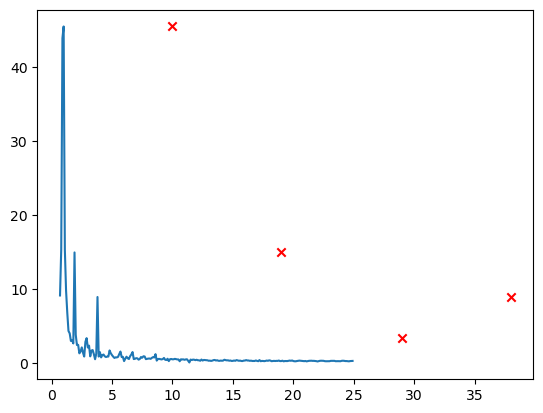

In [3]:
import scipy as sc
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import detecta
import pandas as pd
from matplotlib import pyplot as plt

df=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")
df=df["gravity.y"][2000:2500]
T = 1/50
N = 500
freq=50

y_f = fft(df)
x_f = fftfreq(N, T)[:N//2]
max_peak_height = 0.01*np.nanmax(2/N * np.abs(y_f[0:N//2]))
peaks = detecta.detect_peaks(2/N * np.abs(y_f[0:N//2]), mph=max_peak_height)
print(peaks)
print(y_f[0])
print(abs(y_f[peaks]))
plt.plot(x_f[7:], abs(y_f[7:250]))
plt.scatter(peaks,abs(y_f[peaks]), marker="x", c="red")
plt.show()


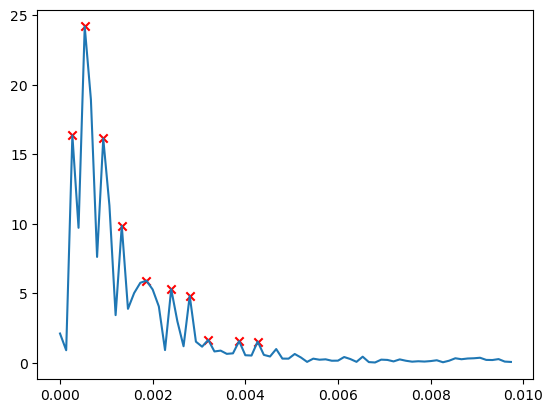

In [9]:
import detecta
import pandas as pd
from matplotlib import pyplot as plt
from numpy.fft import fft
import numpy as np


df=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")
df=noise_filter(df)
df=df["userAcceleration.y"][0:150]
X=fft(df)
N=len(X)
n=np.arange(-1,N)
sr=1/50
T=N/sr
freq=n/T


n_oneside=N//2
x=freq[1:n_oneside]
y=np.abs(X[1:n_oneside])

max_peak_height=np.amax(y)/20
peaks=detecta.detect_peaks(y, mph=max_peak_height)
peaks_x=peaks/T
peaks_y=y[peaks]
plt.plot(x, y)
plt.scatter(peaks_x, peaks_y, marker="x", c="red")

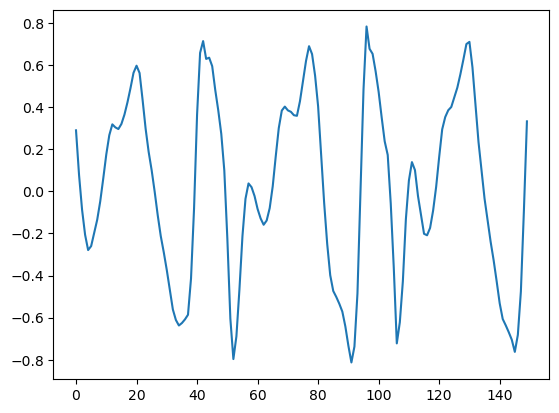

In [10]:
plt.plot(df)

In [ ]:
import scipy as sc
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import detecta
import pandas as pd
from matplotlib import pyplot as plt

df=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")
df=df["gravity.y"][2000:2500]


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf=ExtraTreesClassifier(n_estimators=100)
clf=clf.fit(df.loc[:, df.columns!='class'], df['class'])
print(clf.feature_importances_)


In [ ]:
# mean,median, standard deviation, variance, peak, signal-to-noise-ratio, mean-frequency, band power, occupied bandwidth

In [ ]:
import detecta